In [1]:
#Install statsforecast
%pip install statsforecast

#Install mlforecast. 
#This will also install collected packages: window-ops, utilsforecast, mlforecast
%pip install mlforecast

#Install pmdarima
%pip install pmdarima

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
%pip install lightgbm
%pip install xgboost


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsforecast import StatsForecast
from pmdarima import auto_arima
from statsforecast.models import AutoARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from mlforecast import MLForecast
from mlforecast.target_transforms import Differences
from numba import njit
from window_ops.expanding import expanding_mean
from window_ops.rolling import rolling_mean
import lightgbm as lgb
import xgboost as xgb
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
plt.style.use('ggplot')

D:\Usuarios\byarismendi\AppData\Roaming\Python\Python311\site-packages\statsforecast\core.py:27: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [26]:
file_path = "https://raw.githubusercontent.com/AileenNielsen/TimeSeriesAnalysisWithPython/master/data/AirPassengers.csv"
df = pd.read_csv(file_path)
df['Month'] = pd.to_datetime(df['Month'])
df = df.set_index('Month').resample('MS').mean()
df = df.interpolate() #to interpolate and fill missing values
#df.reset_index(inplace=True)
print(df.head())


            #Passengers
Month                  
1949-01-01        112.0
1949-02-01        118.0
1949-03-01        132.0
1949-04-01        129.0
1949-05-01        121.0


In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 144 entries, 1949-01-01 to 1960-12-01
Freq: MS
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   #Passengers  144 non-null    float64
dtypes: float64(1)
memory usage: 2.2 KB


Leamos los datos y visualicémoslos.

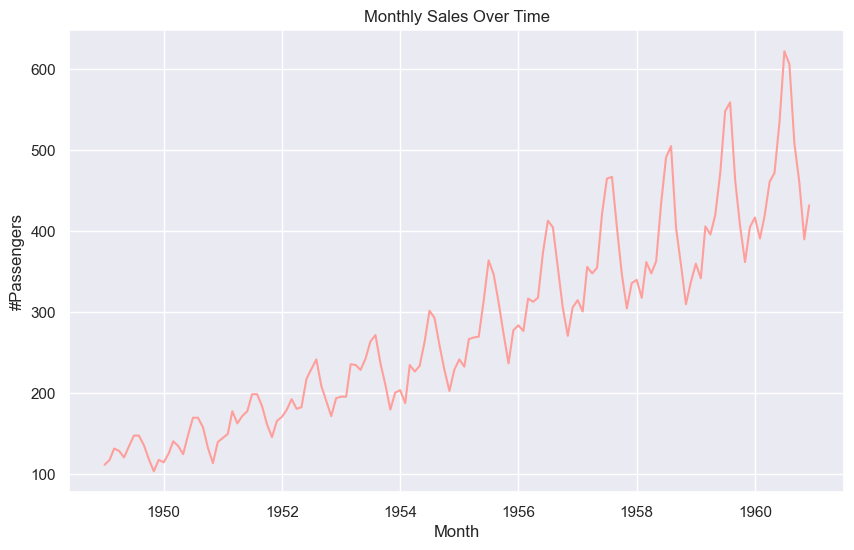

In [28]:
sns.set(style="darkgrid")
plt.figure(figsize=(10, 6))
sns.lineplot(x="Month", y='#Passengers', data=df, color='#ff9f9b')
plt.title('Monthly Sales Over Time')
plt.xlabel('Month')
plt.ylabel('#Passengers')
plt.show()

#Descomposición estacional

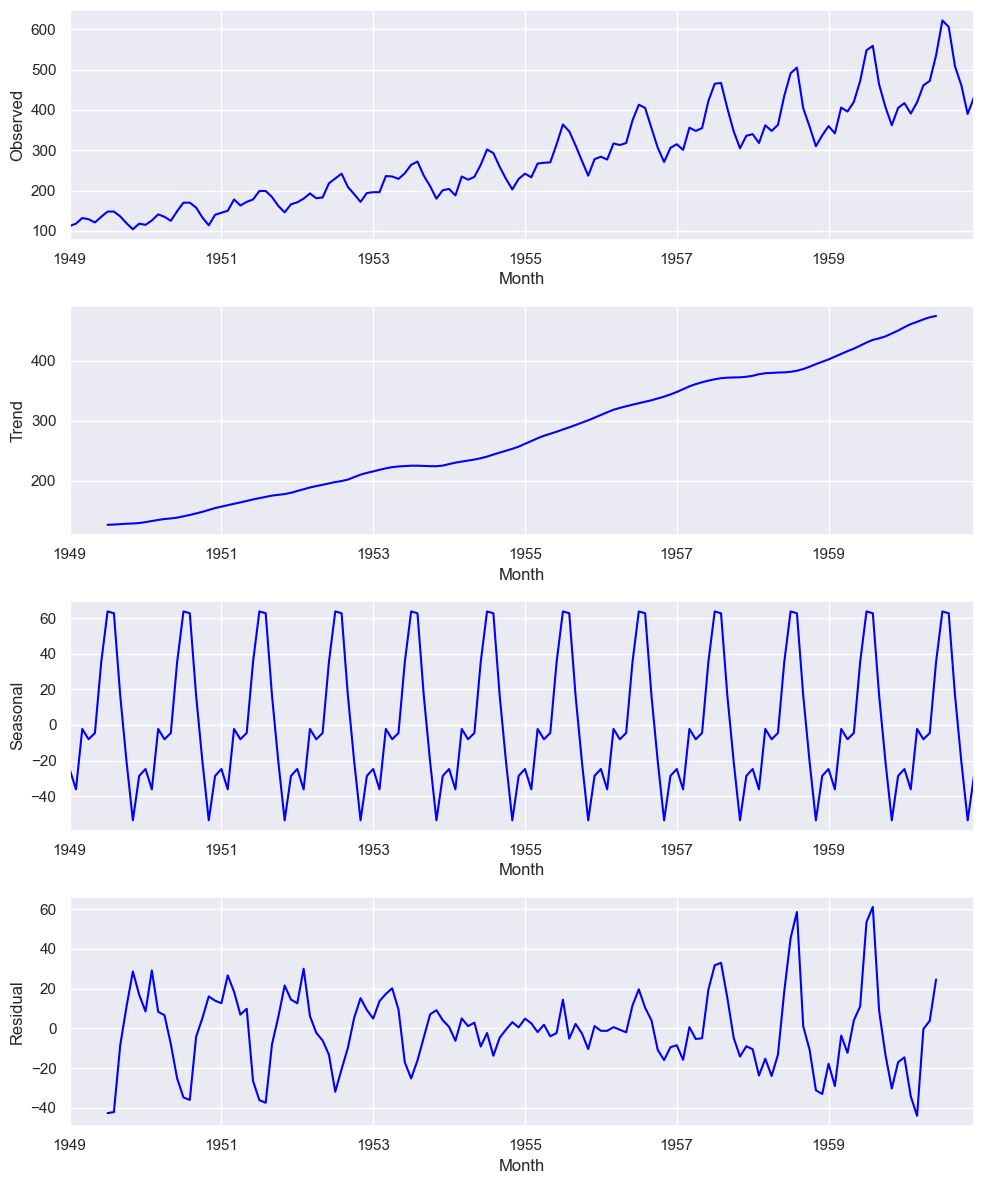

In [29]:
result = seasonal_decompose(df['#Passengers'], model='additive')

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(10, 12))

result.observed.plot(ax=ax1, color="blue")
ax1.set_ylabel('Observed')

result.trend.plot(ax=ax2, color='blue')
ax2.set_ylabel('Trend')

result.seasonal.plot(ax=ax3, color='blue')
ax3.set_ylabel('Seasonal')

result.resid.plot(ax=ax4, color='blue')
ax4.set_ylabel('Residual')

plt.tight_layout()
plt.show()

In [30]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(df['#Passengers'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])


ADF Statistic: 0.8153688792060463
p-value: 0.991880243437641


#Construcción del modelo

In [31]:
df.reset_index(inplace=True)


In [32]:
#Train-Test Split
train_size = int(len(df) * 0.8)
train, test = df.iloc[:train_size], df.iloc[train_size:]

print(f'Train set size: {len(train)}')
print(f'Test set size: {len(test)}')

Train set size: 115
Test set size: 29


In [33]:
df

,Month,#Passengers
0,1949-01-01,112.0
1,1949-02-01,118.0
2,1949-03-01,132.0
3,1949-04-01,129.0
4,1949-05-01,121.0
...,...,...
139,1960-08-01,606.0
140,1960-09-01,508.0
141,1960-10-01,461.0
142,1960-11-01,390.0


In [43]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Month        144 non-null    datetime64[ns]
 1   #Passengers  144 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 2.4 KB


In [34]:
#Forecasting using pmdarima
pmdarima_model = auto_arima(train['#Passengers'], seasonal=True, m=12)
pmdarima_forecast = pmdarima_model.predict(n_periods=len(test))
pmdarima_forecast_df = pd.DataFrame({'Date': test["Month"],
                        'PMDARIMA_Forecast': pmdarima_forecast})

In [35]:
#Forecasting using Exponential Smoothening
ets_model = ExponentialSmoothing(train['#Passengers'], 
            seasonal='mul', seasonal_periods=12).fit()

ets_forecast = ets_model.forecast(steps=len(test))
ets_forecast_df = pd.DataFrame({'Date': test["Month"],
                                'ETS_Forecast': ets_forecast})

In [37]:
#Forecasting using StatsForecast Library
train_ = pd.DataFrame({'unique_id':[1]*len(train),
        'ds': train["Month"], "y":train['#Passengers']})

test_ = pd.DataFrame({'unique_id':[1]*len(test),
        'ds': test["Month"], "y":test['#Passengers']})

sf_forecast = StatsForecast(models = [AutoARIMA(season_length = 12)],freq = 'MS')

sf_forecast.fit(train_)
sf_prediction = sf_forecast.predict(h=len(test))
sf_prediction.rename(columns={'ds': 'Month'}, inplace=True)

D:\Usuarios\byarismendi\AppData\Roaming\Python\Python311\site-packages\statsforecast\core.py:485: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


In [38]:
#Previsión utilizando la biblioteca MLForecast : regresión lineal, regresión de bosque aleatoria, regresión GBM ligera y regresión de aumento de gradiente extremo .
models = [LinearRegression(),
    lgb.LGBMRegressor(verbosity=-1),
    xgb.XGBRegressor(),
    RandomForestRegressor(random_state=0),
]
@njit
def rolling_mean_3(x):
    return rolling_mean(x, window_size=3)
@njit
def rolling_mean_6(x):
    return rolling_mean(x, window_size=6)

fcst = MLForecast(
    models=models,
    freq='MS',
    lags=[1,3,5,7,12],
    lag_transforms={
        1: [expanding_mean],
        3: [rolling_mean_3, rolling_mean_6],
        5: [rolling_mean_3, rolling_mean_6],
        7: [rolling_mean_3, rolling_mean_6],
        12: [rolling_mean_3, rolling_mean_6],
    },
    date_features=['year', 'month', 'day', 'quarter'],
    target_transforms=[Differences([1])])
fcst.fit(train_)
ml_prediction = fcst.predict(len(test_))
ml_prediction.rename(columns={'ds': 'Month'}, inplace=True)

#Evaluación y comparación del desempeño

In [47]:
import pandas as pd

# Supongamos que ya tienes los DataFrames de pronóstico con los nombres:
# sf_prediction, pmdarima_forecast_df, ets_forecast_df, ml_prediction

# Copiar el DataFrame de prueba y establecer el índice en la columna "Month"
fcst_result = test.copy()
fcst_result.set_index("Month", inplace=True)

# Función para asegurarse de que cada DataFrame tenga una columna "Month"
def ensure_month_column(df, reference_df):
    if 'Month' not in df.columns:
        df['Month'] = reference_df['Month'].values
    return df

# Asegurar que todos los DataFrames de pronóstico tengan la columna "Month"
sf_prediction = ensure_month_column(sf_prediction, test)
pmdarima_forecast_df = ensure_month_column(pmdarima_forecast_df, test)
ets_forecast_df = ensure_month_column(ets_forecast_df, test)
ml_prediction = ensure_month_column(ml_prediction, test)

# Establecer "Month" como índice en todos los DataFrames de pronóstico
sf_prediction.set_index("Month", inplace=True)
pmdarima_forecast_df.set_index("Month", inplace=True)
ets_forecast_df.set_index("Month", inplace=True)
ml_prediction.set_index("Month", inplace=True)

# Asegúrate de que las columnas de pronóstico existan en los DataFrames
# y que las predicciones estén alineadas correctamente
fcst_result["AutoARIMA_fcst"] = sf_prediction["AutoARIMA"].values
fcst_result["PMDArima_fcst"] = pmdarima_forecast_df["PMDARIMA_Forecast"].values
fcst_result["ETS_fcst"] = ets_forecast_df["ETS_Forecast"].values
fcst_result["LinearRegression_fcst"] = ml_prediction["LinearRegression"].values
fcst_result["LGBM_fcst"] = ml_prediction["LGBMRegressor"].values
fcst_result["XGB_fcst"] = ml_prediction["XGBRegressor"].values
fcst_result["RandomForest_fcst"] = ml_prediction["RandomForestRegressor"].values

# Visualizar las primeras filas del DataFrame resultante
print(fcst_result)


            #Passengers  AutoARIMA_fcst  PMDArima_fcst    ETS_fcst  \
Month                                                                
1958-08-01        505.0      490.355652     490.337911  483.663371   
1958-09-01        404.0      427.893555     427.883043  422.747902   
1958-10-01        359.0      370.784119     370.771413  364.795810   
1958-11-01        310.0      328.806396     328.794272  315.747712   
1958-12-01        337.0      359.801849     359.789591  353.312845   
1959-01-01        360.0      363.802765     363.790550  357.506107   
1959-02-01        342.0      341.802582     341.790353  343.034302   
1959-03-01        406.0      385.802643     385.790394  394.196013   
1959-04-01        396.0      371.802612     371.790385  380.492302   
1959-05-01        420.0      386.802612     386.790387  382.879405   
1959-06-01        472.0      458.802612     458.790387  442.030091   
1959-07-01        548.0      514.802612     514.790387  490.747526   
1959-08-01        55

In [41]:
#Defining a function to calculate the error metrices
import numpy as np
import pandas as pd

# Definiendo una función para calcular las métricas de error
def calculate_error_metrics(actual_values, predicted_values):
    actual_values = np.array(actual_values)
    predicted_values = np.array(predicted_values)

    metrics_dict = {
        'MAE': np.mean(np.abs(actual_values - predicted_values)),
        'RMSE': np.sqrt(np.mean((actual_values - predicted_values)**2)),
        'MAPE': np.mean(np.abs((actual_values - predicted_values) / actual_values)) * 100,
        'SMAPE': 100 * np.mean(2 * np.abs(predicted_values - actual_values) / (np.abs(predicted_values) + np.abs(actual_values))),
        'MdAPE': np.median(np.abs((actual_values - predicted_values) / actual_values)) * 100,
        'GMRAE': np.exp(np.mean(np.log(np.abs(actual_values - predicted_values) / actual_values)))
    }

    result_df = pd.DataFrame(list(metrics_dict.items()), columns=['Metric', 'Value'])
    return result_df

# Supongamos que tienes un DataFrame fcst_result con las predicciones
actuals = fcst_result['#Passengers']

error_metrics_dict = {}

# Asegúrate de que estás utilizando el DataFrame correcto en el bucle
for col in fcst_result.columns[1:]: 
    predicted_values = fcst_result[col]
    error_metrics_dict[col] = calculate_error_metrics(actuals, predicted_values)['Value'].values  # Extracting 'Value' column

error_metrics_df = pd.DataFrame(error_metrics_dict).T.reset_index()
error_metrics_df.columns = ['Model', 'MAE', 'RMSE', 'MAPE', 'SMAPE', 'MdAPE', 'GMRAE']
error_metrics_df


,Model,MAE,RMSE,MAPE,SMAPE,MdAPE,GMRAE
0,AutoARIMA_fcst,28.529587,35.064640,6.120764,6.341101,6.057917,0.045879
1,PMDArima_fcst,28.547409,35.082813,6.124550,6.345217,6.060148,0.046005
2,ETS_fcst,50.403542,61.843232,10.726855,11.580575,10.447532,0.075039
3,LinearRegression_fcst,31.021877,37.440283,7.152104,7.185313,7.383269,0.050875
4,LGBM_fcst,44.332040,54.381438,10.878859,10.079661,10.720302,0.069730
5,XGB_fcst,19.510140,22.546076,4.723056,4.592487,5.199580,0.027248
6,RandomForest_fcst,27.054828,32.481266,6.518869,6.229710,6.548596,0.044582


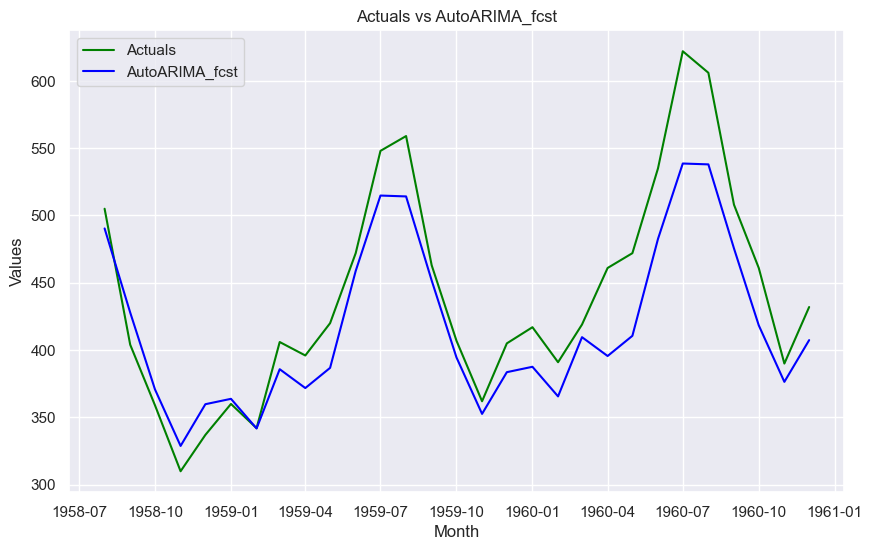

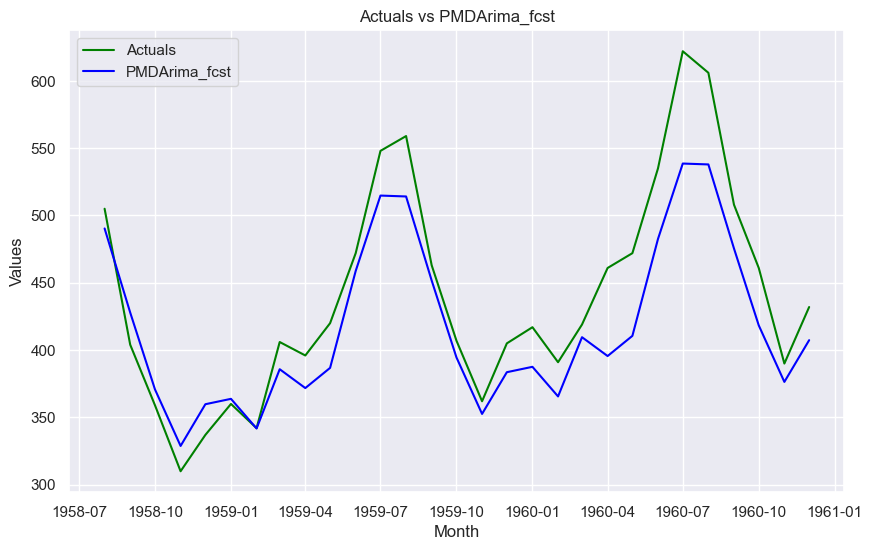

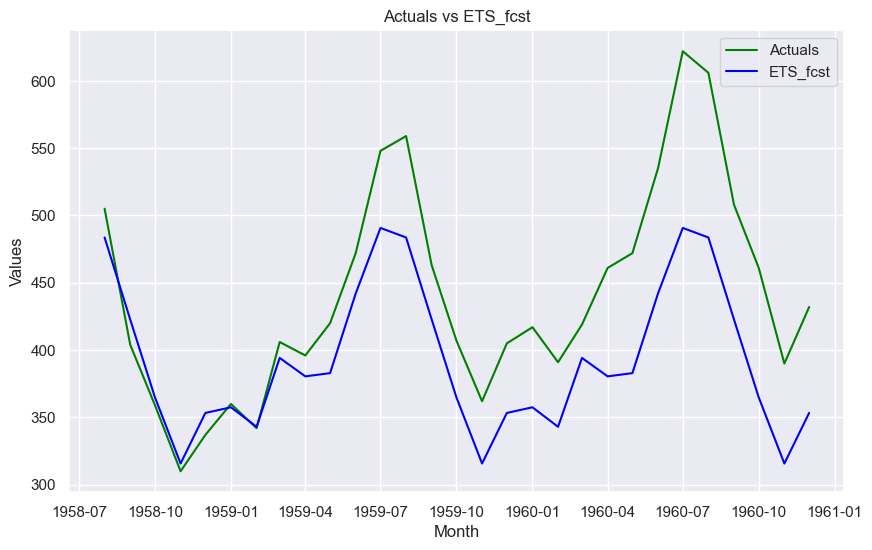

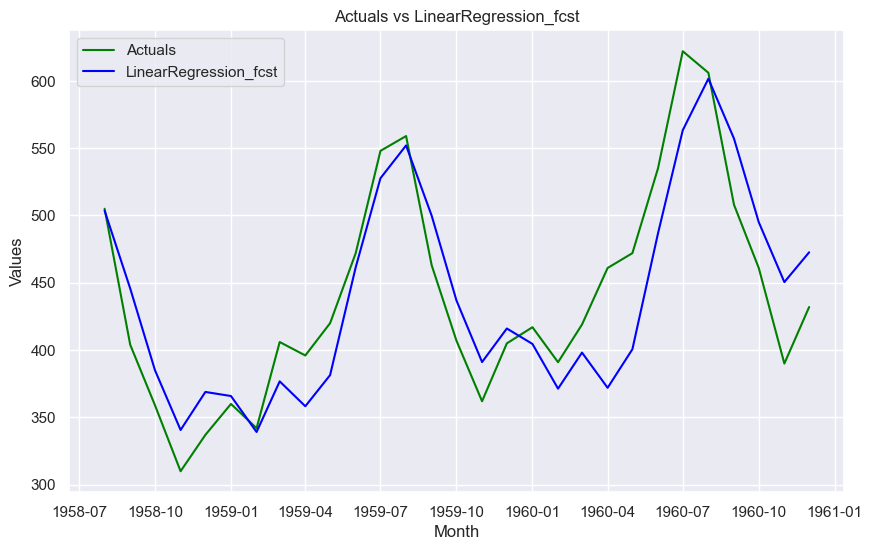

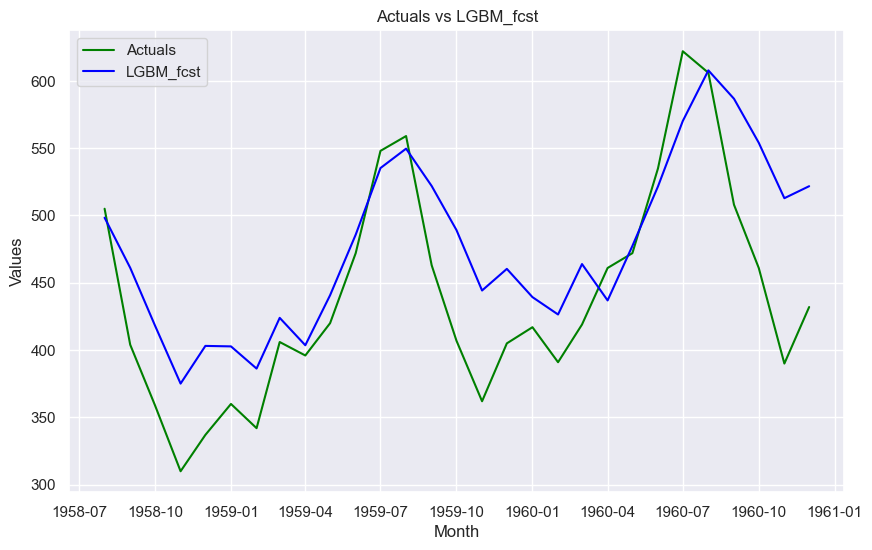

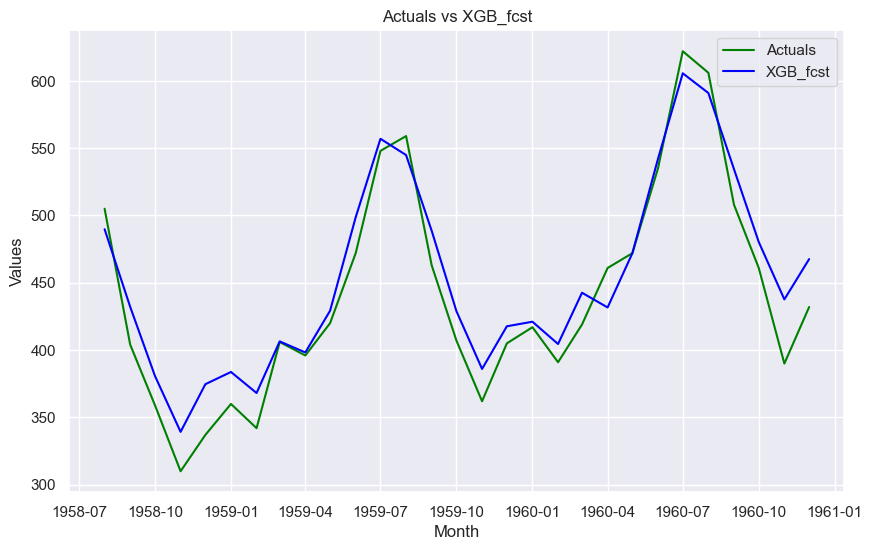

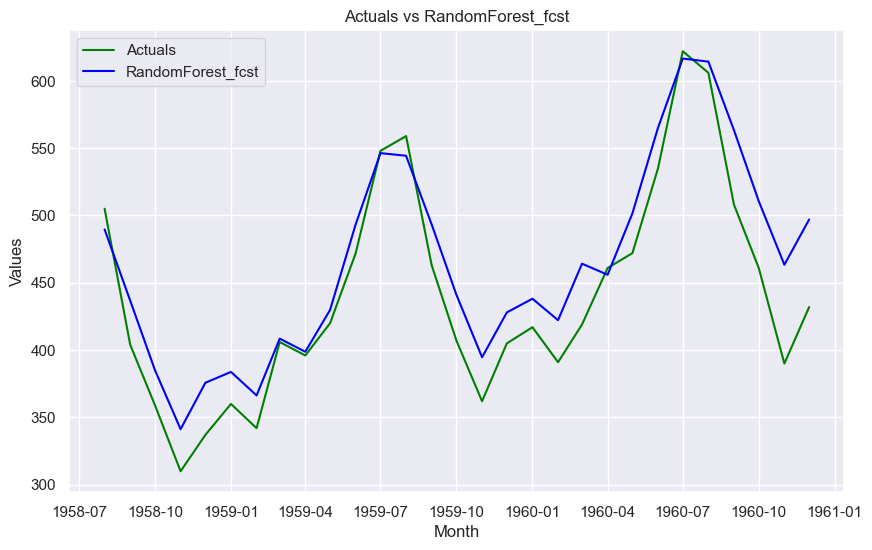

In [42]:
sns.set(style="darkgrid")

for col in fcst_result.columns[1:]:
    plt.figure(figsize=(10, 6))   
    plt.plot(fcst_result.index, fcst_result['#Passengers'], label='Actuals', color='green')
    plt.plot(fcst_result.index, fcst_result[col], label=col, color='blue')
    plt.title(f'Actuals vs {col}')
    plt.xlabel('Month')
    plt.ylabel('Values')
    plt.legend()
    plt.show()